# Detecting Tumors in MRI Brain Scans with Convolutional Neural Networks

### This notebook contains the code necessary to load and classify MRI images as containing a brain tumor or being tumor-free.
#### The process is as follows:
- [Import libraries and functions](#Imports)
- [Get image paths and split into three groups for neural network compatibility (train, validation, test)](#Get-Image-Paths)
- [Load images and remove duplicates](#Load-Image-Data)
- [Reshape data for neural network compatibility ](#Reshape-Image-Data)
- [Use ImageDataGenerator to resample and alter training images model more robust](#ImageDataGenerator)
- [Build and train model](#Build-Model)
- [Visualize model performance](#Visualize-Model-Performance)
- [Analyze model performance with LIME](#Analyze-Model-Performance)

## Imports

In [1]:
# import libraries/packages
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
import math 
import lime.lime_image as li

In [3]:
# import custom functions
import sys
sys.path.append('../../src')

from data_functions import *

# Get Image Paths

### Custom function returns all image files within given directory

In [4]:
# get paths from base directory
base_dir = 'D:/MRI_data/Kaggle'
absent_paths, present_paths = get_img_paths(base_dir)

### Split Paths into Train, Validation, and Test sets with sklearn train_test_split

In [5]:
# define train size for data set
train_size = 0.8 # eighty percent
test_size = 0.15 # fifteen percent
val_size = 0.05 # five percent

# calculate test size for second split
test_size2 = test_size/(1-train_size)

# split absent paths into train and test
absent_train, absent_test = train_test_split(absent_paths, train_size=train_size, random_state=2021)

# split absent test paths into test and validation
absent_test, absent_val = train_test_split(absent_test, train_size=test_size2, random_state=2021)

# split present paths into train and test
present_train, present_test = train_test_split(present_paths, train_size=train_size, random_state=2021)

# split present paths into test and val
present_test, present_val = train_test_split(present_test, train_size=test_size2, random_state=2021)

In [6]:
# combine train and test and validation lists (respectively)
train = absent_train
train.extend(present_train)

test = absent_test
test.extend(present_test)

val = absent_val
val.extend(present_val)

# Load Image Data
### Custom function loads data given path and class specified

In [7]:
# load image data
train_img_data = get_data(train)

val_img_data = get_data(val)

test_img_data = get_data(test)

# Remove Duplicates
### Custom function compares each image and removes duplicates. This is necessary for correctly fitting the model.

In [8]:
# remove duplicates from each set
unique_train_img, train_duplicate = remove_duplicates(train_img_data)
unique_val_img, val_duplicate = remove_duplicates(val_img_data)
unique_test_img, test_duplicate = remove_duplicates(test_img_data)

### View samples of scans with and without tumors present

In [ ]:
labels = ['Tumor Absent', 'Tumor Present']

# create figure hold images
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.flatten()
# plot image data from first [1] train image data (tumor-free brain)
ax[0].imshow(unique_train_img[100][0], cmap='gray')
ax[0].set_title(labels[unique_train_img[100][1]])
ax[0].axis('off')

# plot image data from last [-1] train image data (tumor patient brain)

ax[1].imshow(unique_train_img[-22][0], cmap='gray')
ax[1].set_title(labels[unique_train_img[-22][1]])
ax[1].axis('off')

# save figure
plt.savefig("../figures/scan_comparison.jpg", transparent=True)

# Reshape Image Data

In [ ]:
# separate image data and identifiers
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for data, label, _ in unique_train_img:
    x_train.append(data)
    y_train.append(label)
    
for data, label, _ in unique_val_img:
    x_val.append(data)
    y_val.append(label)
    
for data, label, _ in unique_test_img:
    x_test.append(data)
    y_test.append(label)

In [ ]:
# scale data and convert to np.array for efficiency

x_train = np.array(x_train)/255

x_test = np.array(x_test)/255

x_val = np.array(x_val)/255

In [ ]:
img_size = 150

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)

x_test = x_test.reshape(-1, img_size, img_size, 3)

x_val = x_val.reshape(-1, img_size, img_size, 3)

# ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(\
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False, 
                            zca_whitening=False, 
                            rotation_range=30,
                            zoom_range=0.25,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=False)

# Build Model

In [ ]:
metrics = ['Recall', 'accuracy']
learning_rate_reduction_loss = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=10**-9)
learning_rate_reduction_acc = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=10**-9)

model= Sequential()
model.add(Conv2D(32, (3,3), strides =1, padding = 'same', activation ='relu', input_shape = (150,150,3)))

model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (2,2), strides =1, padding ='same', activation='relu'))
model.add(Dropout(0.15))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides =1, padding ='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides =1, padding ='same', activation='selu'))


model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=metrics)
model.summary()

In [15]:
epochs = 12
model_history = model.fit(datagen.flow(x_train, y_train), epochs=epochs, validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction_loss, learning_rate_reduction_acc])

Epoch 1/12
80/80 [==============================] - 66s 829ms/step - loss: 0.7097 - recall: 0.9748 - accuracy: 0.8421 - val_loss: 0.4352 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 2/12
80/80 [==============================] - 64s 801ms/step - loss: 0.4028 - recall: 0.9794 - accuracy: 0.8461 - val_loss: 0.4465 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 3/12
80/80 [==============================] - ETA: 0s - loss: 0.3692 - recall: 0.9826 - accuracy: 0.8528
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
80/80 [==============================] - 62s 780ms/step - loss: 0.3692 - recall: 0.9826 - accuracy: 0.8528 - val_loss: 0.4012 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 4/12
80/80 [==============================] - 66s 831ms/step - loss: 0.2910 - recall: 0.9739 - accuracy: 0.8677 - val_loss: 0.3633 - val_recall: 0.9452 - val_accuracy: 0.8343
Epoch 5/12
80/80 [==============================] - 65s 817ms/step - loss: 0.2711 - recall: 0.94

# Visualize Model Performance
### Display changes in accuracy by epoch to help understand model learning progress

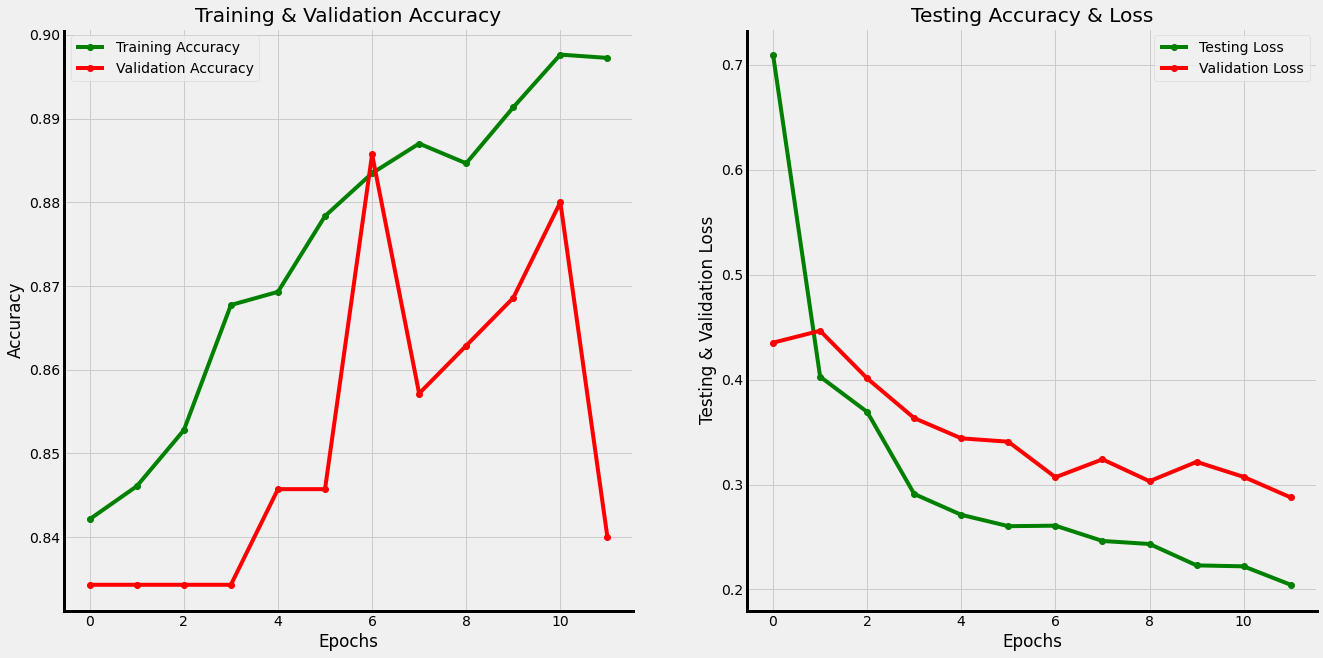

In [16]:
plot_metrics(model.history, filename='final')

### Create a confusion matrix representing the model's corect and incorrect predictions

              precision    recall  f1-score   support

    No Tumor       0.62      0.75      0.68        81
       Tumor       0.95      0.91      0.93       429

    accuracy                           0.89       510
   macro avg       0.79      0.83      0.81       510
weighted avg       0.90      0.89      0.89       510

[[ 61  20]
 [ 37 392]]


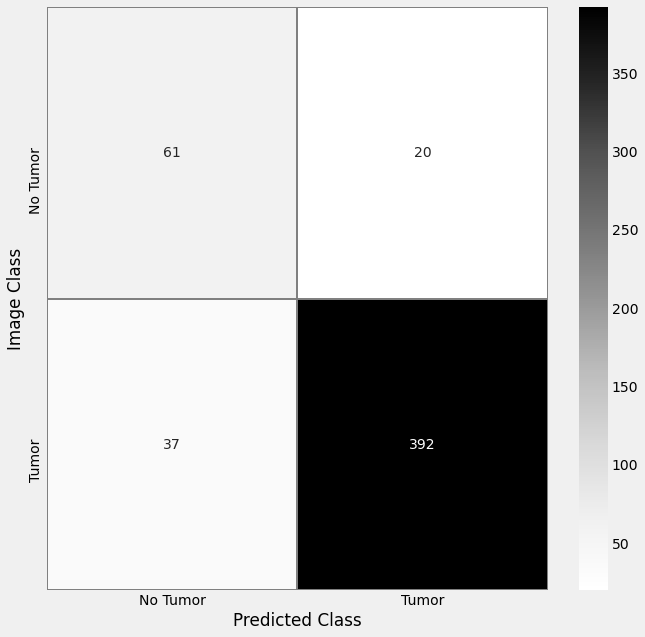

In [17]:
plot_confusion_matrix(model, x_test, y_test, filename='final')

# Analyze Model Performance

### Get all image classifications and compare to predictions. Store for use in identifying error types.

In [18]:
# get model predictions
predictions = (model.predict(x_test) > 0.5).astype('int32')
# identify image classifications
good_preds0 = []
good_preds1 = []
type_1 = []
type_2 = []

for i in range(len(y_test)):
    
    if y_test[i] == predictions[i]:
        if y_test[i] == 0:
            good_preds0.append(i)
        
        else:
            good_preds1.append(i)
    
    elif y_test[i] == 1:
        type_1.append(i)
        
    else:
        type_2.append(i)
        
good_preds0 = np.array(good_preds0)
good_preds1 = np.array(good_preds1)
type_1 = np.array(type_1)
type_2 = np.array(type_2)

## TIME for LIME
### Use LIME techniques to visualize model's analysis of images

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


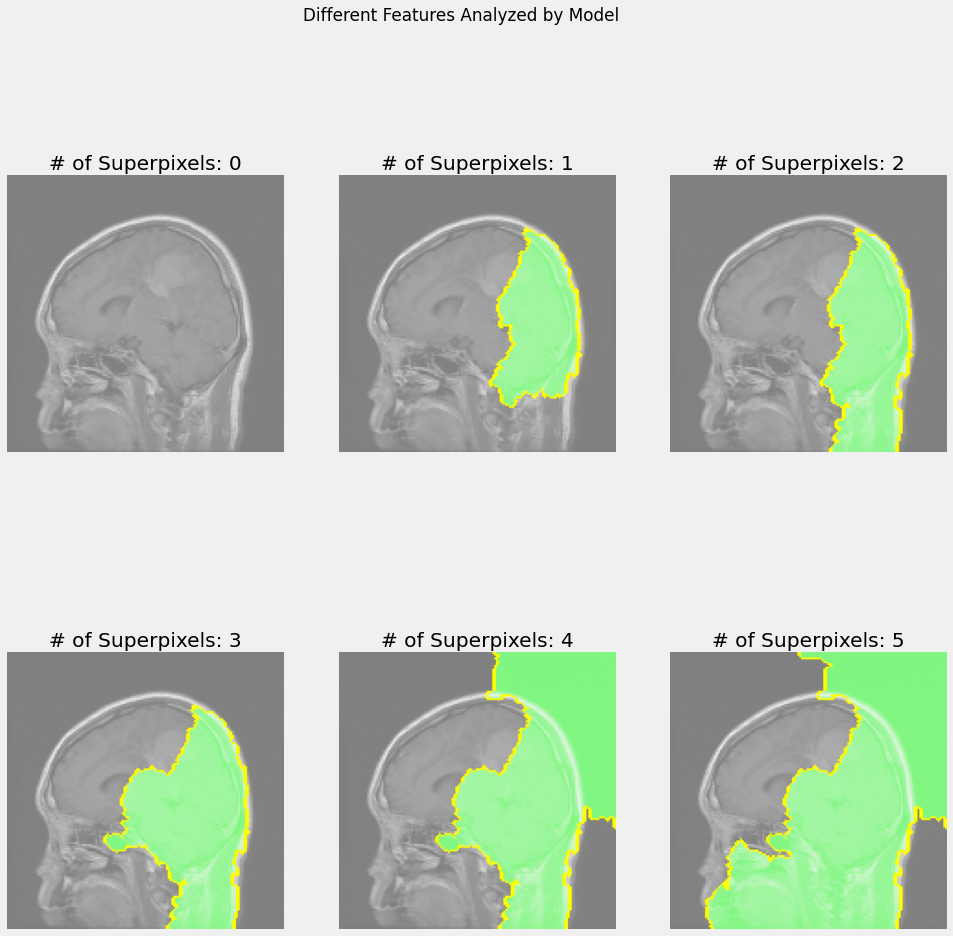

In [19]:
# analyze correctly identified image
lime_image(model, x_test[good_preds1[2]], min_superpixels=0, max_superpixels=6, filename='tumor_correct[2]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


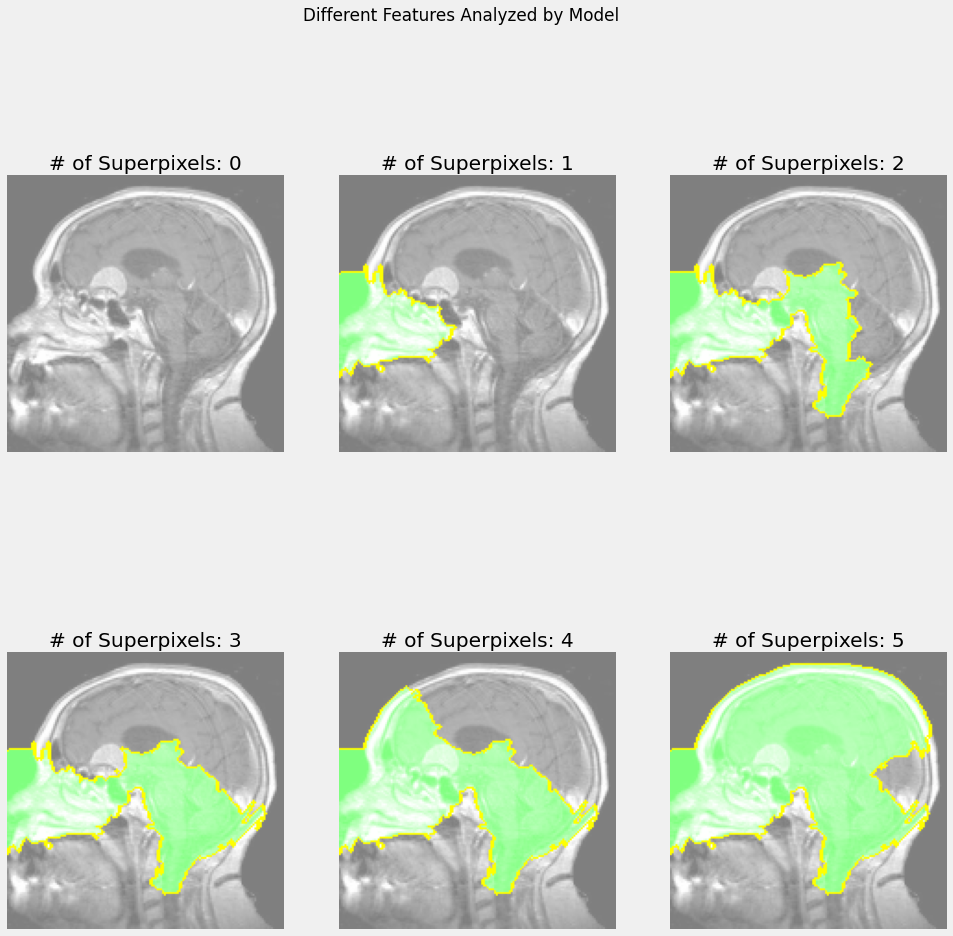

In [20]:
lime_image(model, x_test[good_preds1[3]], min_superpixels=0, max_superpixels=6, filename='tumor_correct[3]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


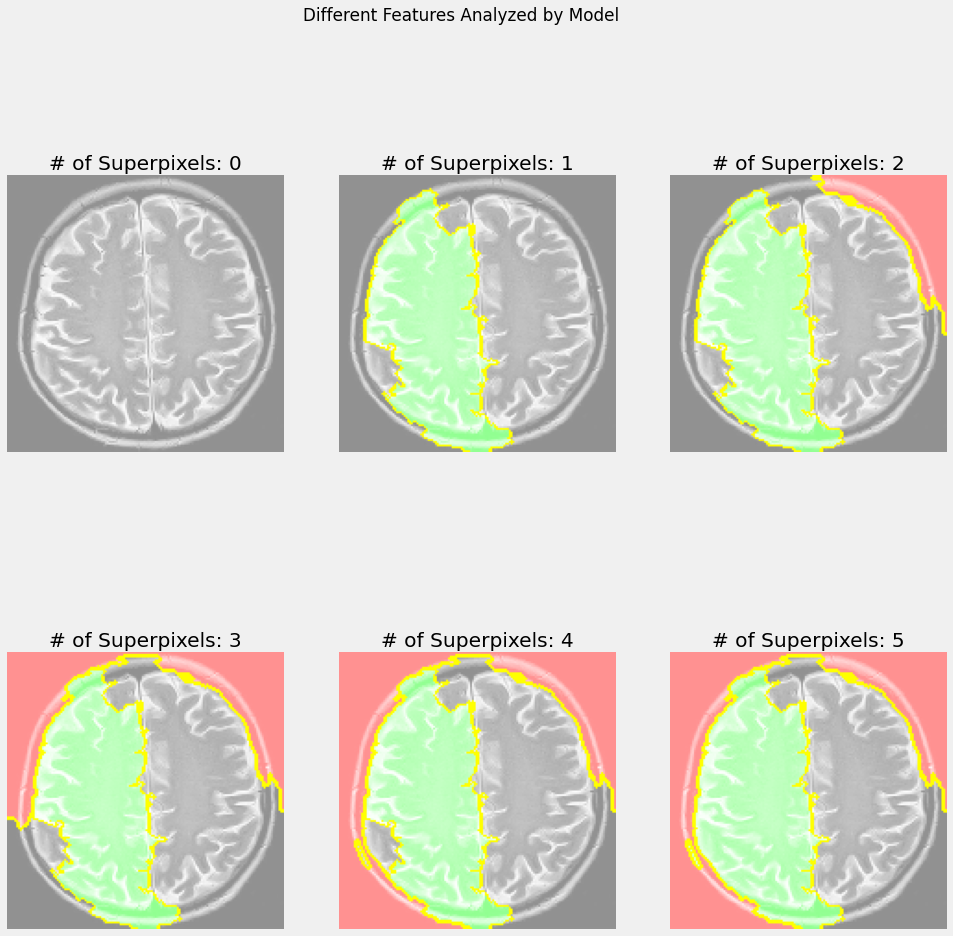

In [21]:
lime_image(model, x_test[good_preds0[0]], min_superpixels=0, max_superpixels=6, filename='no_tumor_correct[0]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


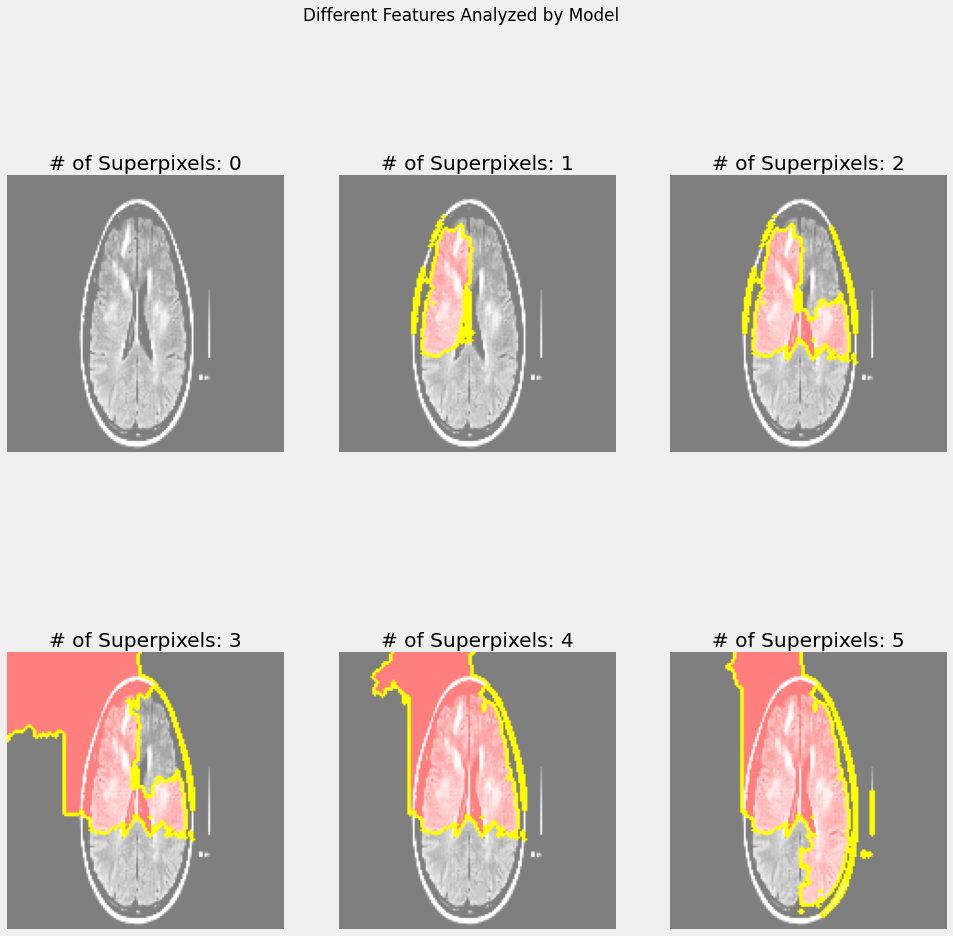

In [22]:
lime_image(model, x_test[good_preds0[1]], min_superpixels=0, max_superpixels=6, filename='no_tumor_correct[1]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


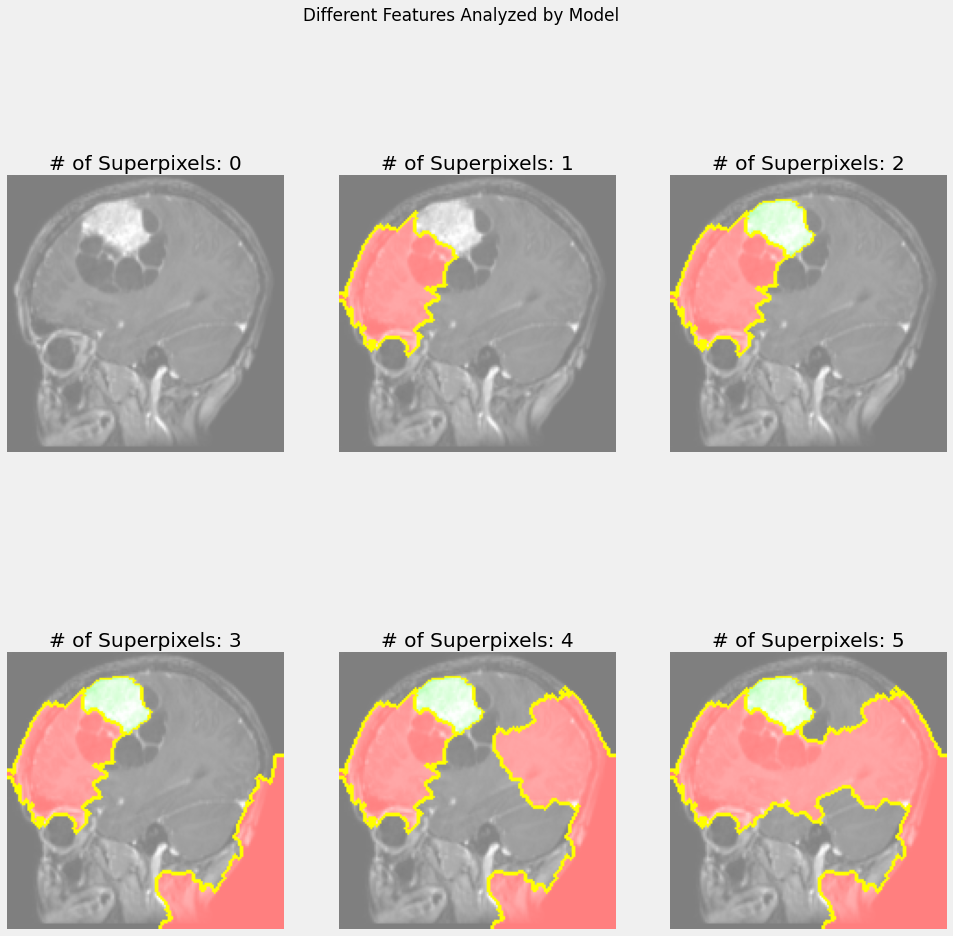

In [23]:
lime_image(model, x_test[type_1[0]], min_superpixels=0, max_superpixels=6, filename='type_1_error[0]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


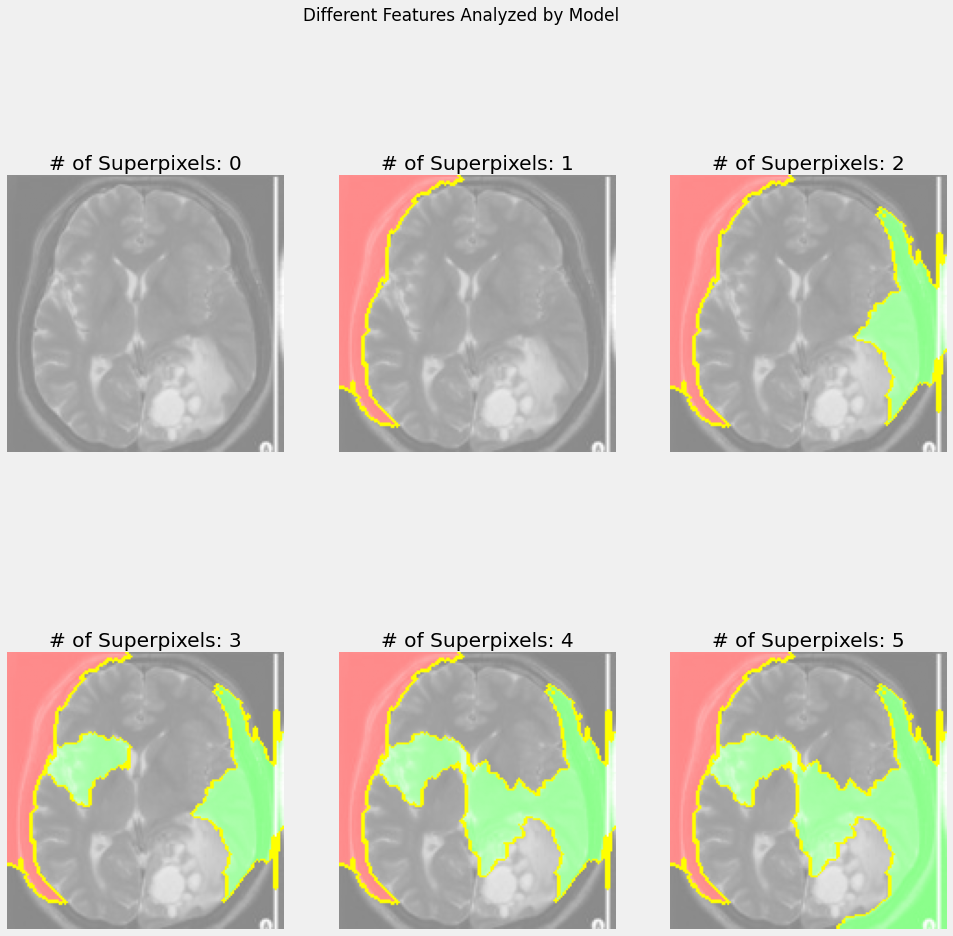

In [24]:
lime_image(model, x_test[type_1[1]], min_superpixels=0, max_superpixels=6, filename='type_1_error[1]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


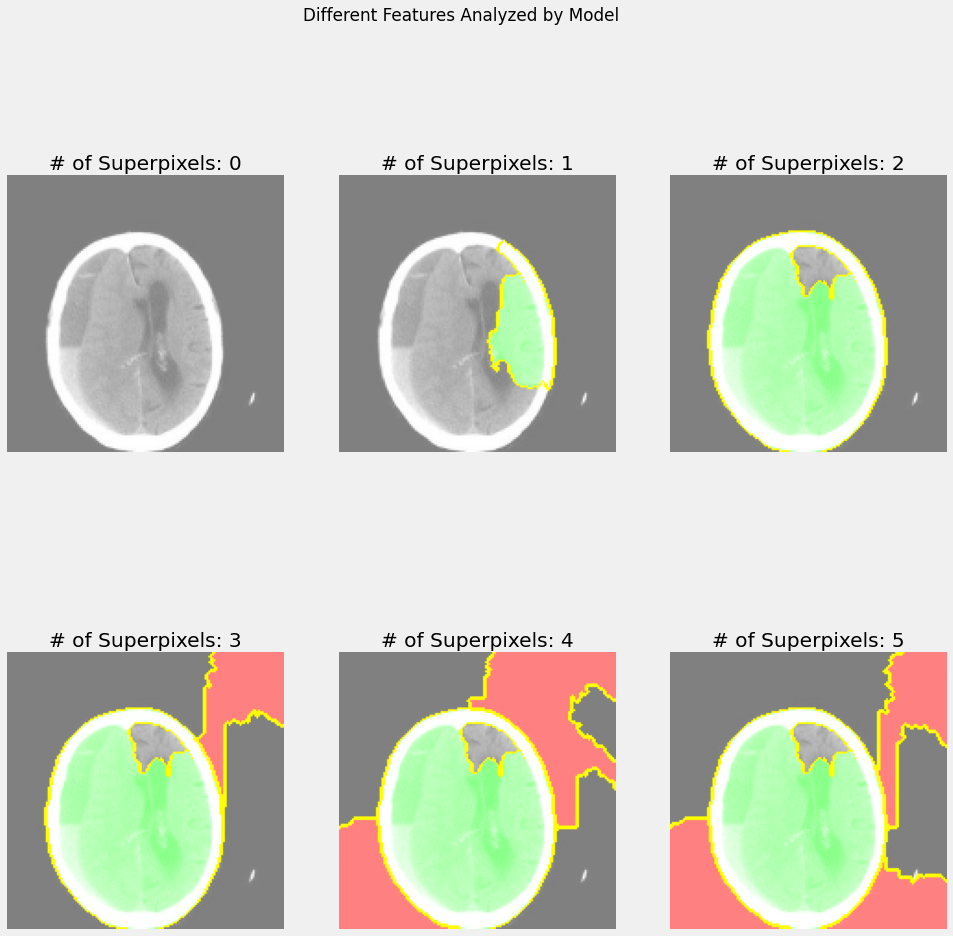

In [25]:
lime_image(model, x_test[type_2[0]], min_superpixels=0, max_superpixels=6, filename='type_2_error[0]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


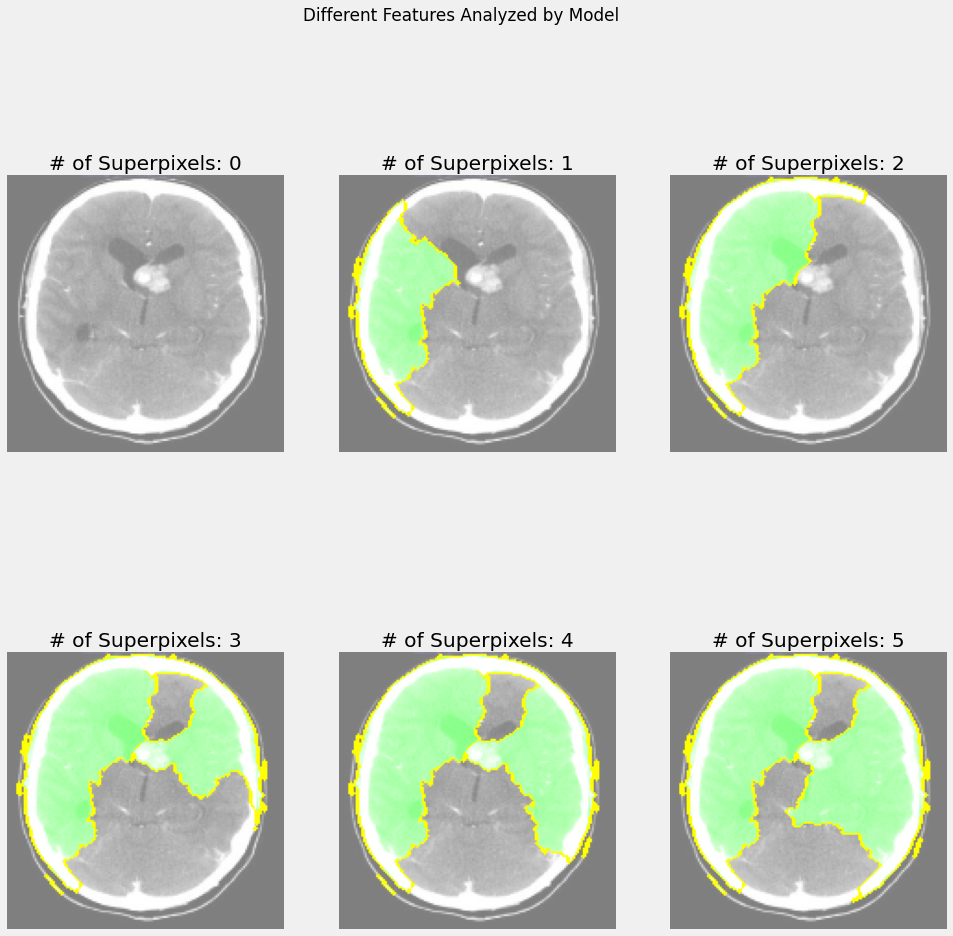

In [26]:
lime_image(model, x_test[type_2[1]], min_superpixels=0, max_superpixels=6, filename='type_2_error[1]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


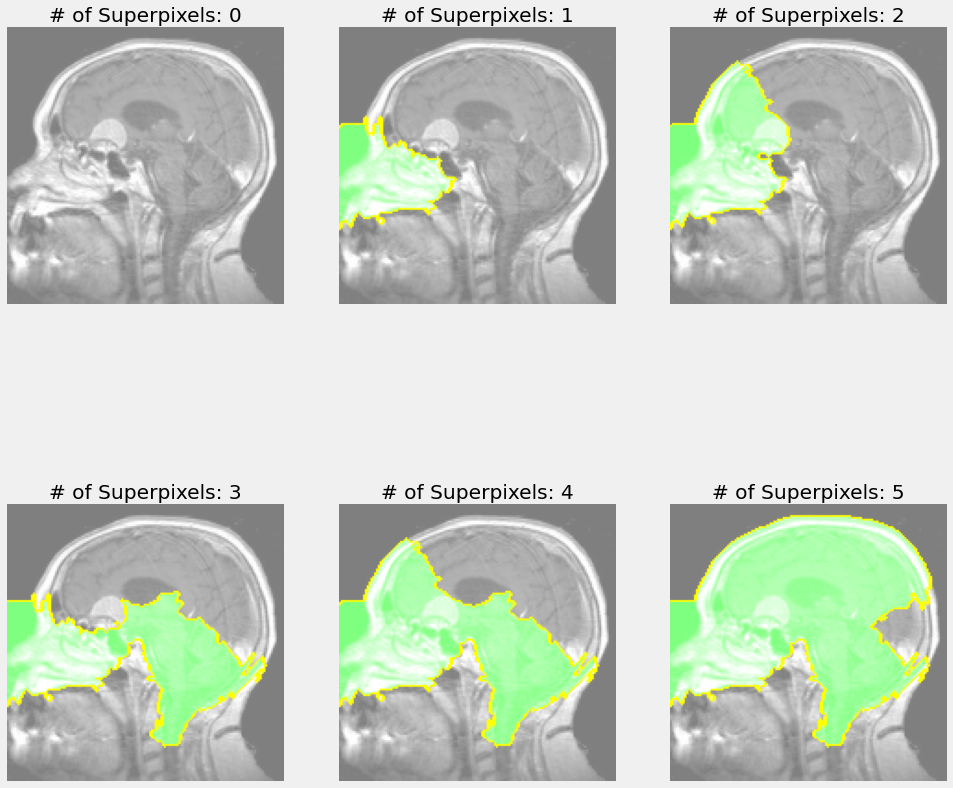

In [30]:
# analyze correctly identified image
num = 3
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=6, filename=f'tumor_correct[{num}]', suptitle=None)

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


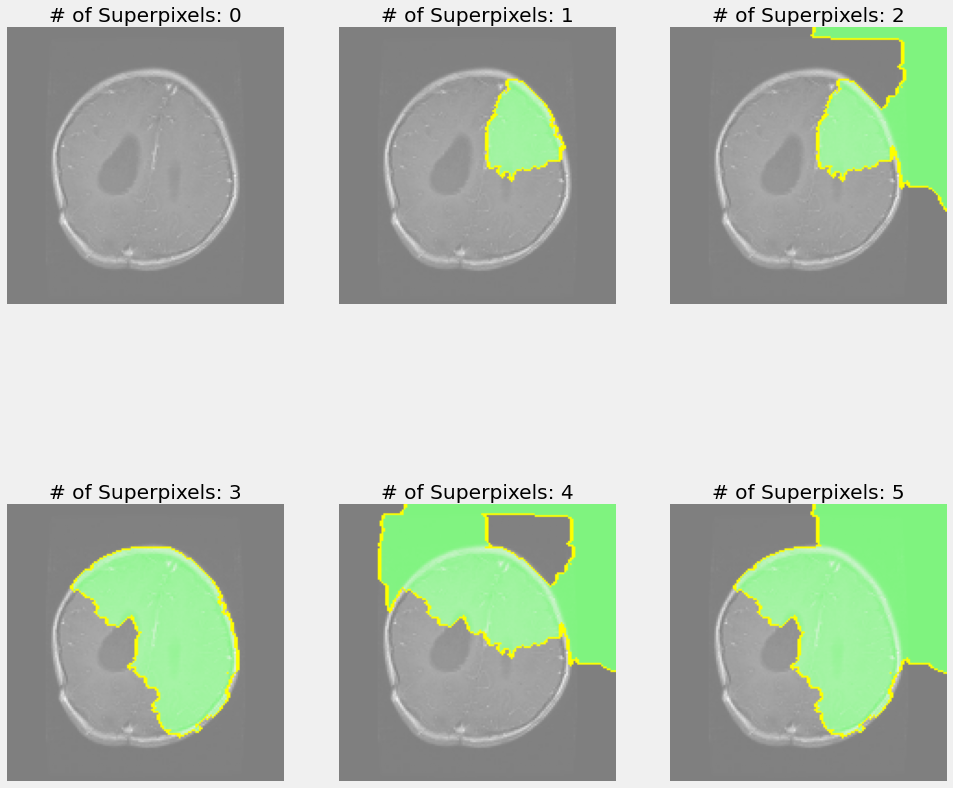

In [31]:
# analyze correctly identified image
num = 4
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=6, filename=f'tumor_correct[{num}]', suptitle=None)

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


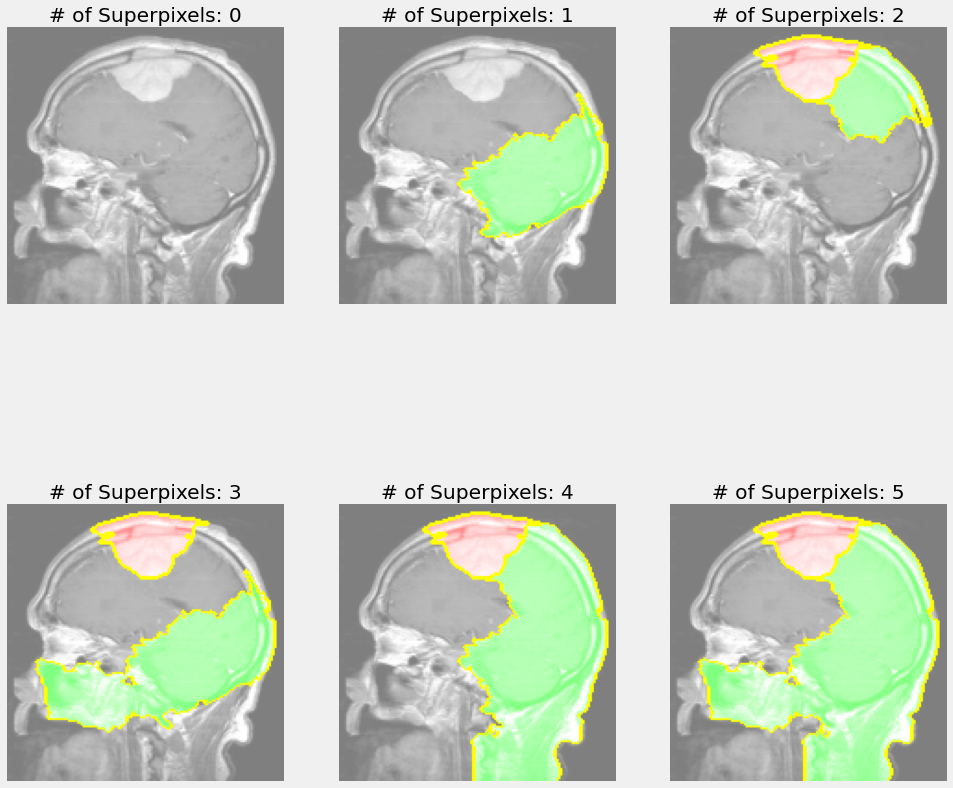

In [32]:
# analyze correctly identified image
num = 50
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=6, filename=f'tumor_correct[{num}]', suptitle=None)